In [1]:
import sys, os
sys.path.insert(0, '../../../residual2vec_')

In [2]:
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'

In [3]:
# standard imports
import numpy as np
import pandas as pd
import pickle as pkl
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# codebase
from utils import snakemake_utils, score


/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [5]:

DIR = '../../../final_128'
def get_embs(dataset, directory, root=DIR):
    model_to_embs = {
        "fairwalk+deepwalk": "{}/{}_fairwalk_deepwalk.npy",
        "fairwalk+node2vec": "{}/{}_fairwalk_node2vec.npy",
        "crosswalk+deepwalk": "{}/{}_crosswalk_deepwalk.npy",
        "crosswalk+node2vec": "{}/{}_crosswalk_node2vec.npy",
        "GCN+deepwalk+random": "{}/{}_gcn_None_deepwalk_deepwalk_embs.npy",
        "GCN+deepwalk+r2v": "{}/{}_gcn_None_deepwalk_r2v_embs.npy",
        "GCN+node2vec+random": "{}/{}_gcn_None_node2vec_deepwalk_embs.npy",
        "GCN+node2vec+r2v": "{}/{}_gcn_None_node2vec_r2v_embs.npy",
        "GAT+deepwalk+random": "{}/{}_gat_None_deepwalk_deepwalk_embs.npy",
        "GAT+deepwalk+r2v": "{}/{}_gat_None_deepwalk_r2v_embs.npy",
        "GAT+node2vec+random": "{}/{}_gat_None_node2vec_deepwalk_embs.npy",
        "GAT+node2vec+r2v": "{}/{}_gat_None_node2vec_r2v_embs.npy",
        "deepwalk": "{}/{}_deepwalk_128_embs.npy",
        "node2vec": "{}/{}_node2vec_128_embs.npy",
        "residual2vec": "{}/{}_residual2vec_128_embs.npy"
    }
    folder = root + '/' + dataset + '/' + dataset + '_' + directory
    ret = {}
    for i in model_to_embs:
        ret[i] = np.load(model_to_embs[i].format(folder, dataset))
        
        
    return ret



In [6]:
embs_airport = get_embs('airport', 'one')



embs_polblog = get_embs('polblog', 'one')
embs_polbook = get_embs('polbook', 'four')
embs_pokec = get_embs('pokec', 'one')

y_airport = snakemake_utils.get_dataset("airport").get_grouped_col()
N_airport = y_airport.shape[0]
y_pokec = snakemake_utils.get_dataset("pokec").get_grouped_col()
N_pokec = y_pokec.shape[0]
y_polblog = snakemake_utils.get_dataset("polblog").get_grouped_col()
N_polblog = y_polblog.shape[0]
y_polbook = snakemake_utils.get_dataset("polbook").get_grouped_col()
N_polbook = y_polbook.shape[0]



# g = sns.FacetGrid(data=df, col="model", hue="model", row="dataset")
# g.map(sns.displot, x="scores")

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz
Using existing file polbooks.gml


In [7]:
df = []
df.append(pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["GAT+deepwalk+random"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["GAT+deepwalk+r2v"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["GAT+deepwalk+random"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["GAT+deepwalk+r2v"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["GAT+deepwalk+random"], y_airport, 'std'),
            score.get_node_parity(embs_airport["GAT+deepwalk+r2v"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["GAT+deepwalk+random"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["GAT+deepwalk+r2v"], y_pokec, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['pokec'] * 2 * N_pokec
    ),
    'architecture': ['gat'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec)
    
})
      )
df.append(
    pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["GCN+deepwalk+random"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["GCN+deepwalk+r2v"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["GCN+deepwalk+random"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["GCN+deepwalk+r2v"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["GCN+deepwalk+random"], y_airport, 'std'),
            score.get_node_parity(embs_airport["GCN+deepwalk+r2v"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["GCN+deepwalk+random"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["GCN+deepwalk+r2v"], y_pokec, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['pokec'] * 2 * N_pokec
    ),
    'architecture': ['gcn'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec)
    
    
    
})
    )

df.append(
    pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["deepwalk"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["residual2vec"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["deepwalk"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["residual2vec"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["deepwalk"], y_airport, 'std'),
            score.get_node_parity(embs_airport["residual2vec"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["deepwalk"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["residual2vec"], y_pokec, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['pokec'] * 2 * N_pokec
    ),
    'architecture': ['word2vec'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec)
    
    
    
})
)
df = pd.concat(df, axis=0, ignore_index=True)

df.shape


(9822180, 4)

In [8]:
df.head()

,disparity per node,model,dataset,architecture
0,0.400590,baseline,polbook,gat
1,0.362707,baseline,polbook,gat
2,0.469259,baseline,polbook,gat
3,0.731781,baseline,polbook,gat
4,0.389968,baseline,polbook,gat


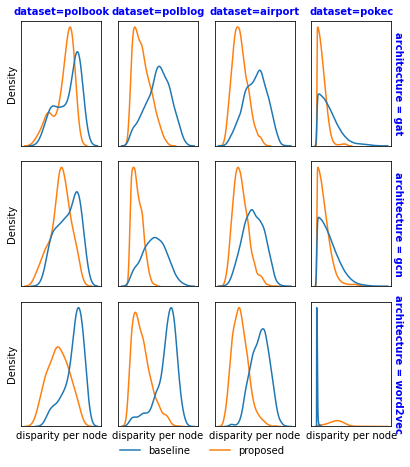

In [9]:
g = sns.displot(data=df, x="disparity per node", kind='kde', hue='model', col="dataset", 
                row='architecture',
                facet_kws=dict(sharey=False, sharex=False, margin_titles=True, despine=False))
# g.fig.set_size_inches(6, 10)
g.fig.set_size_inches(6, 6)
g.set_titles(col_template="dataset={col_name}", fontweight='bold', fontsize=20, color="blue")
for (i,j,k), data in g.facet_data():
    ax = g.facet_axis(i, j)
    ax.set_yticks([])
    ax.set_xticks([])

#     ax.set_title(str(i) + '_' + str(j))
# sns.move_legend(g, "bottom", bbox_to_anchor=(.55, .45), frameon=False)
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncol=2)
g.legend.set_title(None)